In [30]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
import itertools
import pyomo.environ as env
import ast
from pyomo.environ import *
#solver = env.SolverFactory("ipopt")

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [31]:
import watertap as wt

In [32]:
#### MODEL FUNCTIONS ####

In [33]:
# LINKS COMING OUT OF SOURCE NODE AND GOING INTO FIRST UP MUST EQUAL FEEDWATER TOTAL! 
def source_flow_constraint(m, source_node): #RENAME THIS CONSTRAINT
    
    sum_of_inflows = 0
    for link in T.out_edges(source_node):
        sum_of_inflows = sum_of_inflows + m.FlowInLinkSegments[T.edges[link]['name']]

    max_flow_in = T.nodes[source_node]['Flow']
        
    return sum_of_inflows == max_flow_in

In [34]:
# SOURCE FLOW MASS BALANCE
def node_mass_balance_constraint(m, node):
        
    flow_in = 0
    for edge in T.in_edges(node):
        flow_in = flow_in + m.FlowInLinkSegments[T.edges[edge]['name']]
    flow_out = 0
    for edge in T.out_edges(node):
        flow_out = flow_out + m.FlowInLinkSegments[T.edges[edge]['name']]

    return (-0.000000001, flow_in - flow_out, 0.000000001)

In [35]:
# NEW WITH UNIT PROCESS #
# recovered stream from unit process
def calculate_recovered_streams(m, unit_process):
    
    sum_of_treated_flow = get_sum_of_up_outflow(m, unit_process, 'recovery_stream')
    sum_of_up_inflow = calculate_up_source_inflow(m, unit_process)

    return sum_of_treated_flow == sum_of_up_inflow * T.nodes[unit_process]['recovery_factor']

# waste stream from unit process --> TODO: FOR SOME REASON FAILS WHEN THIS IS ON.
def calculate_waste_streams(m, unit_process):
    
    sum_of_waste_flow = get_sum_of_up_outflow(m, unit_process, 'waste_stream')
    sum_of_up_inflow = calculate_up_source_inflow(m, unit_process)
           
    if T.nodes[unit_process]['recycle_factor'] > 0.0001: 
        return Constraint.Skip
    else: 
        return sum_of_waste_flow == sum_of_up_inflow * T.nodes[unit_process]['waste_factor']

    
def get_sum_of_up_outflow(m, unit_process, link_type):
    print(link_type)
    
    sum_of_outflow = 0
    for edge in T.out_edges(unit_process):
        if T.edges[edge]['type'] == link_type:
            sum_of_outflow = sum_of_outflow + m.FlowInLinkSegments[T.edges[edge]['name']]
    
    return sum_of_outflow

In [6]:
# recovered stream from unit process
#def calculate_recovered_streams(m, link):
#    if 'treated' in link:
#        print('treated:', link)
#        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0] #change column names for df so easier to follow
#        sum_of_source_inflows = calculate_up_source_inflow(m, unit_process)
        #sum_of_recycle_inflows = calculate_up_recycle_inflow(m, unit_process)
#        sum_of_up_inflow = sum_of_source_inflows #+ sum_of_recycle_inflows
        
#        return m.FlowInLinkSegments[link] == sum_of_up_inflow * T.nodes[unit_process]['recovery_factor']
    
#    else: return Constraint.Skip

In [7]:
# waste stream from unit process
#def calculate_waste_streams(m, link):
#    if 'waste' in link:
#        print('waste:', link)
#        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0] #change column names for df so easier to follow
#        sum_of_source_inflows = calculate_up_source_inflow(m, unit_process)
        
#        if T.nodes[unit_process]['recycle_factor'] > 0: return Constraint.Skip
#        else: return m.FlowInLinkSegments[link] == sum_of_source_inflows * T.nodes[unit_process]['waste_factor']
#    else: return Constraint.Skip

In [8]:
# recycle stream from unit process ->>> NOT  USED BECAUSE IT AUTOMATICALLY GETS MAXIMIZED -> NEEDS TO BE EDITED IF
# TO BE USED
#def calculate_recycle_streams(m, link):
#    if wt.get_graph_chars.get_link_df(T).loc[link]['type'] == 'recycle_stream':
#        print('recycle:', link)
#        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0] #change column names for df so easier to follow
#        sum_of_source_inflows = calculate_up_source_inflow(m, unit_process)

#        return m.FlowInLinkSegments[link] == sum_of_source_inflows * T.nodes[unit_process]['recycle_factor']
#    else: return Constraint.Skip

In [36]:
# inflow to unit process
def calculate_up_source_inflow(m, unit_process):
    
    sum_of_source_inflows = 0;
    for link in T.in_edges(unit_process): #THIS WAS PREVIOUSLY OUT EDGES
        link_name = T.edges[link]['name']
        sum_of_source_inflows = sum_of_source_inflows + m.FlowInLinkSegments[link_name]
    
    return sum_of_source_inflows

In [37]:
# SETS MAX AMOUNT THAT CAN BE RECYCLED
# THIS COULD BE REDONE IN FUTURE TO DETERMINE OPTIMAL AMOUNT TO RECYCLE
def max_recycle_streams(m, link):
    if wt.get_graph_chars.get_link_df(T).loc[link]['type'] == 'recycle_stream':
        ('calculates recycle')
        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0]
        max_recycle_amount = m.FlowInLinkSegments[('%s_source_stream' % unit_process)] * T.nodes[unit_process]['recycle_factor']
        return m.FlowInLinkSegments[link] <= max_recycle_amount
    else: return Constraint.Skip

In [38]:
#THIS IS FOR END NODE!!!!! BETTER NAMING NEEDED FOR FUNCTIONS
def calculate_recovered_water(m, end_node): # AT NODE

    recovered_flow = 0; # CAN DO SUM INSTREAD with list of nodes/links? outflow_link_list = []; 

    for up_outflow_link in T.in_edges(end_node): # TO DO MAKE FUNCTION
    
        recovered_flow = recovered_flow + m.FlowInLinkSegments[T.edges[up_outflow_link]['name']]
    
    return model.RecoveredFlow[end_node] == recovered_flow

adding unit process to network: microfiltration_a
adding unit process attributes: microfiltration_a


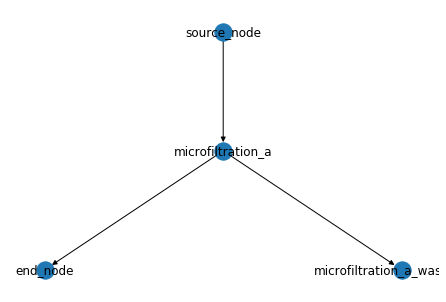

In [99]:
# imports all trains from library/unit processes
unit_process_name_list = [wt.unit_process_library_list[0]] #[wt.unit_process_library_list[0], wt.unit_process_library_list[1]] 
#wt.unit_process_library_list

# FROM AND TO PROCESS TO BE CHANED TO SINGLE VS TRAIN OPTION - HAVE TWO OPTIONS. START WITH TRAIN.
T = wt.treatment_train_design.create_train(unit_process_name_list=unit_process_name_list,  # OLDER VERSION HAD TO AND FROM PROCESS BUT THAT IS FOR ADDING ONE PROCESS AT A TIME
                                            source_water_reference = 'Poseidon',
                                            source_water_type = 'Wastewater',
                                            source_water_case_study ='Typical untreated domestic wastewater',
                                            enduse_water_reference = 'Poseidon',
                                            enduse_water_type = 'Environmental',
                                            enduse_water_case_study = 'EPA: Environmental Reuse',
                                            flow = 1000.0)

wt.display.treatment_train_graph(T)

In [100]:
#!!!! FUNCTIONS FOR DESIGN CAPABILITIES!!!!
# REMOVE ONE OR PROCESSES IF NEEDED;;;; TO DO: ACTUALLY REMOVE THE NODES THAT ARE NOT CONNECTED So they don't
# show up when plotting.
#T = wt.filter_processes.remove(T, process_name = 'microfiltration_a')
#T = wt.filter_processes.select_single_processes(T, process_name = 'microfiltration_a')
#T = wt.filter_processes.select_multiple_processes(T, process_name_list = ['microfiltration_a', 'ultrafiltration_a'])


In [101]:
# ADD ANOTHER SOURCE 
T = wt.treatment_train_design.add_multiple_water_sources(T,
                                              number_of_additional_sources = 1,
                                              source_water_reference = 'Poseidon',
                                              source_water_type = 'Environmental',
                                              source_water_case_study = 'EPA: Environmental Reuse',
                                              source_to_node_names=[['source_b', wt.unit_process_library_list[0]]],
                                              flow = 500)


adding another water source: source_b


In [102]:
# ADD ANOTHER END USE 
T = wt.treatment_train_design.add_multiple_water_enduses(T,
                                              number_of_additional_ends = 1,
                                              enduse_water_reference = 'Poseidon',
                                              enduse_water_type = 'Wastewater',
                                              enduse_water_case_study = 'Typical untreated domestic wastewater',
                                              node_to_end_names= [[wt.unit_process_library_list[0], 'end_b']],
                                              min_flow = 0)

adding another water use: end_b


In [90]:
# IMPORT FEEDWATER DATA ----> NOT NEEDED ANYMORE TO RUN MODEL ----> BUT GOOD CAPABILITY TO HAVE
#fw_filename = 'case_study_water_sources_and_uses.csv'
#feedwater_data = wt.importfile.feedwater(input_file = fw_filename,
#                                         reference = 'Poseidon',
#                                         case_study = 'Typical untreated domestic wastewater',
#                                         water_type = 'Wastewater',
#                                         source_or_use = 'Source')

#feedwater_data

In [91]:
#### CAPABILITY LIST ####

#### WATER TREATMENT MMODEL DESIGN CAPABILITIES ####
# create a single unit process model
# create a single unit process model with a recovery stream
# create a single unit process with multiple source streams
# create a single unit process with multiple use streams
# add another unit process in parralel
# remove a unit process
# filter from a range of unit process to create a system/optimization problem
# TO DO: SAVE TREATMENT TRAIN. LOAD TREATMENT TRAIN --> ANNA.

# MODELING AND ANALYSES CAPABILITIES #
# simulate a single unit process (optimize if equations were given).
# simulat a single unit process model with a recovery stream (max recovery amount specified by user)
# optimize and select between multiple unit processes for single unit train
    # optimize above accounting for recyling streams, multiple sources, multiple uses

In [103]:
#recycle flow fraction could be defined from part of waste stream or based on UP chars (UP chars for now)
# how to apply to multiple streams?
#wt.treatment_train_design.
# ----> THE SOURCE STREAM NEEDS TO BE DEFINED -> WHICH STREAM RECYCLED FLOW GOES TO. IN MODEL. NEEDS TO BE CHECKED.
# ----> DOES NOT OPTIMIZE CORRECTLY FOR MULTIPLE SOURCE NODES
T = wt.treatment_train_design.add_recycle_stream(T,
                       from_unit_process = 'microfiltration_a',
                       to_unit_process = 'microfiltration_a',
                       recyle_fraction_of_waste = 1,
                       number_of_affected_streams = 1)

updating unit process attributes: microfiltration_a


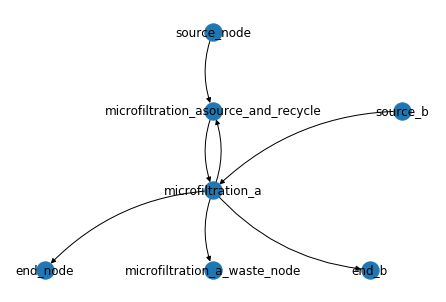

In [104]:
wt.display.treatment_train_graph(T, with_recycle = True)

In [183]:
model = env.ConcreteModel()
#M = wt.build_model.maximize_treated_flow(T, model, unit_process_name_list)
M = build_model(T, model)
solver = env.SolverFactory("ipopt")
solver.solve(M)

/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


ValueError: Cannot load a SolverResults object with bad status: error

In [177]:
for x in model.LinkSet:
    print(x, ':', round(env.value(model.FlowInLinkSegments[x]), 2))

microfiltration_a_source_stream : 1000.0
microfiltration_a_treated_stream : 1472.5
microfiltration_a_waste_stream : 27.5
microfiltration_a_recycle_stream : 50.0
source_b_source_microfiltration_a_stream : 500.0
microfiltration_a_source_and_recycle_stream : 1050.0


In [61]:
for recyle_fraction_of_waste in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

    unit_process_name_list = wt.unit_process_library_list
    T = wt.treatment_train_design.create_train(unit_process_name_list=unit_process_name_list,  # OLDER VERSION HAD TO AND FROM PROCESS BUT THAT IS FOR ADDING ONE PROCESS AT A TIME
                                                source_water_reference = 'Poseidon',
                                                source_water_type = 'Wastewater',
                                                source_water_case_study ='Typical untreated domestic wastewater',
                                                enduse_water_reference = 'Poseidon',
                                                enduse_water_type = 'Environmental',
                                                enduse_water_case_study = 'EPA: Environmental Reuse',
                                                flow = 1000.0)

    T = wt.treatment_train_design.add_recycle_stream(T,
                           from_unit_process = 'microfiltration_a',
                           to_unit_process = 'microfiltration_a',
                           recyle_fraction_of_waste = recyle_fraction_of_waste,
                           number_of_affected_streams = 1) #
    
    
    model = env.ConcreteModel()
    M = build_model(T, model)
    solver = env.SolverFactory("ipopt")
    result = solver.solve(M)
    
    print('RECYCLED AMOUNT:', recyle_fraction_of_waste)
    
    for x in model.LinkSet:
        if 'treated' in x:
            print(x, ':', round(env.value(model.FlowInLinkSegments[x]), 2))
    
    cost.append()
    flow.append()
    up_chosen.append()
    

adding unit process to network: microfiltration_a
adding unit process to network: ultrafiltration_a
adding unit process to network: uv_a
adding unit process attributes: microfiltration_a
adding unit process attributes: ultrafiltration_a
adding unit process attributes: uv_a
updating unit process attributes: microfiltration_a


/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


RECYCLED AMOUNT: 0.5
microfiltration_a_treated_stream : 0.0
ultrafiltration_a_treated_stream : 0.0
uv_a_treated_stream : 990.0
adding unit process to network: microfiltration_a
adding unit process to network: ultrafiltration_a
adding unit process to network: uv_a
adding unit process attributes: microfiltration_a
adding unit process attributes: ultrafiltration_a
adding unit process attributes: uv_a
updating unit process attributes: microfiltration_a
RECYCLED AMOUNT: 0.6
microfiltration_a_treated_stream : 0.0
ultrafiltration_a_treated_stream : 0.0
uv_a_treated_stream : 990.0
adding unit process to network: microfiltration_a
adding unit process to network: ultrafiltration_a
adding unit process to network: uv_a
adding unit process attributes: microfiltration_a
adding unit process attributes: ultrafiltration_a
adding unit process attributes: uv_a
updating unit process attributes: microfiltration_a
RECYCLED AMOUNT: 0.7
microfiltration_a_treated_stream : 0.0
ultrafiltration_a_treated_stream :

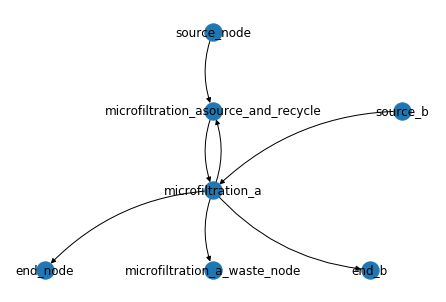

In [105]:
wt.display.treatment_train_graph(T, with_recycle = True)

In [106]:
model = env.ConcreteModel()

model.LinkSet = env.Set(initialize=wt.get_graph_chars.get_link_list(T)) # all links in network
model.UnitProcesses = env.Set(initialize=unit_process_name_list) # all unit processes
model.SourceNodes = env.Set(initialize=wt.get_graph_chars.get_source_nodes(T)) # all source nodes
model.RecoveredWaterNodes = env.Set(initialize=wt.get_graph_chars.get_recovered_water_nodes(T)) # all recovered water
model.AllNoneSourceEndNodes = env.Set(initialize=wt.get_graph_chars.get_all_none_source_end_nodes(T))

#inflow links to UPs
#model.UnitInflowLinkSet = env.Set(initialize=wt.get_graph_chars.get_inflow_links(T, unit_process_name_list))

# flow in and out of processes
model.FlowInLinkSegments = env.Var(model.LinkSet, bounds=(0,None))

# final recovered flow
model.RecoveredFlow = env.Var(model.RecoveredWaterNodes, bounds=(0,None))

In [107]:
model.CalculateRecoveredFlows = env.Constraint(model.UnitProcesses, rule=calculate_recovered_streams)
#model.CalculateRecycleFlows = env.Constraint(model.LinkSet, rule=calculate_recycle_streams)

recovery_stream


In [108]:
#model.CalculateWasteFlows = env.Constraint(model.UnitProcesses, rule=calculate_waste_streams)

In [109]:
model.CalculateRecycleRecoveredFlows1 = env.Constraint(model.LinkSet, rule=max_recycle_streams)

In [110]:
# Equations for mass balance
model.NodeMassBalanceConstraint = env.Constraint(model.AllNoneSourceEndNodes, rule=node_mass_balance_constraint)

In [111]:
model.CheckUnitInletFlows = env.Constraint(model.SourceNodes, rule=source_flow_constraint)

In [112]:
# Calculate recovered water
model.CalculateRecoveredWater = env.Constraint(model.RecoveredWaterNodes, rule=calculate_recovered_water)

In [113]:
model.objective_function = env.Objective(
    #expr=sum(model.FlowInLinkSegments[x] for x in model.LinkSet), # max flows all links -> simulation
    expr=sum(model.RecoveredFlow[x] for x in model.RecoveredWaterNodes), # can do this for node?
    sense=env.maximize)

solver = env.SolverFactory("ipopt")
solver.solve(model) #, tee=True)


/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 8, 'Number of variables': 9, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.12\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.11269497871398926}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [114]:
for x in model.LinkSet:
    print(x, ':', round(env.value(model.FlowInLinkSegments[x]), 2))

microfiltration_a_source_stream : 1000.0
microfiltration_a_treated_stream : 736.25
microfiltration_a_waste_stream : 27.5
microfiltration_a_treated_end_b_stream : 736.25
microfiltration_a_recycle_stream : 50.0
source_b_source_microfiltration_a_stream : 500.0
microfiltration_a_source_and_recycle_stream : 1050.0


In [134]:
def build_model(T, model):
    model = env.ConcreteModel()
    
    # SETS
    model.LinkSet = env.Set(initialize=wt.get_graph_chars.get_link_list(T)) # all links in network
    model.UnitProcesses = env.Set(initialize=unit_process_name_list) # all unit processes
    model.SourceNodes = env.Set(initialize=wt.get_graph_chars.get_source_nodes(T)) # all source nodes
    model.RecoveredWaterNodes = env.Set(initialize=wt.get_graph_chars.get_recovered_water_nodes(T)) # all recovered water
    model.AllNoneSourceEndNodes = env.Set(initialize=wt.get_graph_chars.get_all_none_source_end_nodes(T))

    # VARIABLES
    model.FlowInLinkSegments = env.Var(model.LinkSet, bounds=(0,None))
    model.RecoveredFlow = env.Var(model.RecoveredWaterNodes, bounds=(0,None))

    # CONSTRAINTS
    model.CalculateRecoveredFlows = env.Constraint(model.UnitProcesses, rule=calculate_recovered_streams)
    model.CalculateRecycleRecoveredFlows1 = env.Constraint(model.LinkSet, rule=max_recycle_streams)    
    model.NodeMassBalanceConstraint = env.Constraint(model.AllNoneSourceEndNodes, rule=node_mass_balance_constraint)    
    model.CheckUnitInletFlows = env.Constraint(model.SourceNodes, rule=source_flow_constraint)
    model.CalculateRecoveredWater = env.Constraint(model.RecoveredWaterNodes, rule=calculate_recovered_water)

    # OPTIMIZATION
    
    return model

In [135]:
model = env.ConcreteModel()
M = build_model(T, model)
solver = env.SolverFactory("ipopt")
solver.solve(M)

ERROR: Rule failed when generating expression for constraint
    CalculateWasteFlows with index microfiltration_a: NameError: name
    'unit_process' is not defined
ERROR: Constructing component 'CalculateWasteFlows' from data=None failed:
    NameError: name 'unit_process' is not defined


NameError: name 'unit_process' is not defined

In [ ]:
##### MAYBE CODES #####

In [ ]:
def add_unit_process(G, unit_process_name='unit_process', from_process_lib='False',
                    from_process='None', to_process='None'):
    print('adding unit process', unit_process_name)
    
    G.add_edges_from([('source_node', unit_process_name, {'name': 'source_stream'}), 
                      (unit_process_name, 'end_node', {'name': 'treated_stream'})])
    
    #add option to read in multiple from and to
    #add option to import for existing list if from_process_lib is true
    
    return G

In [ ]:
feedwater = dict()
for row in range(0, len(feedwater_data)):
    feedwater[feedwater_data.Variable[row]] = feedwater_data.Value[row]